# **RI Measurement Operator Tutorial**

## Description

This tutorial is focused on a [Python implementation of the measurement operator](https://github.com/basp-group/RI-measurement-operator/tree/python) for small-scale monochromatic intensity imaging in **r**adio **i**nterferometry (RI). It provides detailed instructions on how to generate the measurement operator from a given Fourier sampling pattern and how to utilise it to simulate measurements. It can be launched directly in Jupyter using the Jupyter Notebook file [tutorial_ri_measurement_operator_python.ipynb](https://github.com/basp-group/RI-measurement-operator/blob/python/tutorial_ri_measurement_operator_python.ipynb).

By default, the repository utilises the [pytorch-finufft](https://flatironinstitute.github.io/pytorch-finufft/) NUFFT library proposed by:
> A. H. Barnett, J. Magland, and L. af Klinteberg, A parallel nonuniform fast Fourier transform library based on an “exponential of semicircle" kernel, _SIAM Journal on Scientific Computing_, 41(5), C479-C504, 2019.

Optionally, [PyNUFFT](https://pynufft.readthedocs.io/en/latest/) or [TorchKbNufft](https://torchkbnufft.readthedocs.io/en/stable/) can be used as an alternative NUFFT library. Both are based on:
> J. A. Fessler and B. P. Sutton, Nonuniform Fast Fourier Transforms Using Min-Max Interpolation, _IEEE Trans. Image Process._, 51(2), 560-574, 2003.

# RI Measurement Operator Model (NUFFT)

Assuming a narrow field of view and in absence of direction dependent effects, at a given time instant, each pair of antennas acquires a noisy complex measurement, termed visibility, corresponding to a Fourier component of the sought radio emission. The collection of the sensed Fourier modes accumulated over the total observation period forms the Fourier sampling pattern, describing an incomplete coverage of the 2D Fourier plane.

Under these considerations, the measurement operator model reduces to a Fourier sampling operator which reads:

\begin{equation}
\boldsymbol{\Phi} = \boldsymbol{GFZ},
\end{equation}

where $\boldsymbol{\Phi} \in \mathbb{C}^{N\times M}$ is the measurement operator corresponding to the non-uniform Fourier transform (NUFFT), $M$ is the number of measurements, and $N$ is the image dimension (i.e. number of pixels). $\boldsymbol{G} \in \mathbb{C}^{M \times P}$  is a sparse interpolation matrix whose rows are convolutional kernels centered at the associated Fourier modes (i.e. $\boldsymbol{uv}$ points), $\boldsymbol{F} \in \mathbb{C}^{P \times P}$ is the 2D Discrete Fourier Transform, and $\boldsymbol{Z} \in \mathbb{R}^{P \times N}$ is a zero-padding operator which also incorporates the correction for the convolution performed through the de-gridding matrix $\boldsymbol{G}$, resulting in a zero-padded image of size $P$. 

# Clone Repository
In your perferred terminal application, create or change to the desired directory you would like the [R2D2-SII](https://github.com/basp-group/R2D2-SII) repository to be cloned to. Then run the following command. 

``` bash
git clone https://github.com/basp-group/RI-measurement-operator/tree/python
cd RI-measurement-operator
```

# Dependencies

## Python Packages

All required Python packages are listed in the [requirements](requirements.txt) file. Python version `3.10` or higher is required.

Install the packages using the command below:

```bash
pip install -r requirements.txt
```

## NUFFT Packages

The data fidelity layers are computed using the Non-Uniform Fast Fourier Transform (NUFFT) operator, which is implemented in the python branch of the submodule [RI-measurement-operator](https://github.com/basp-group/RI-measurement-operator/tree/python). The default NUFFT package used is [pytorch-finufft](https://flatironinstitute.github.io/pytorch-finufft/), which is included in the [requirements](requirements.txt) file. If GPU with cuda driver is available, an additional package is required for `pytorch-finufft` to be able to utilise the GPU, using the command:

```bash
pip install cufinufft
```

PyNUFFT and TorchKbNUFFT are optionally available, which can be installed using the following commands:

- [PyNUFFT](https://pynufft.readthedocs.io/en/latest/).

```bash
pip install pynufft
```

- [TorchKbNufft](https://torchkbnufft.readthedocs.io/en/stable/).

```bash
pip install torchkbnufft
```

# Generate RI Measurement Operator

We first import all the required Python packages.

In [1]:
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from pysrc.utils.io import load_data_to_tensor
from pysrc.utils.gen_imaging_weights import gen_imaging_weights
import torch
from math import *

plt.rcParams.update({'font.size': 15})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

We consider a simulated Fourier sampling pattern using VLA, provided in [data/test.mat](data/test.mat). The file contains the $\boldsymbol{uvw}$ coordinates in meters and the observation frequency in Hz. Load the variables of interest.

In [7]:
uvw_data_file_path = "data/test.mat"
uvw_data_file = loadmat(uvw_data_file_path, variable_names=["u", "v", "w", "frequency"])

u = uvw_data_file["u"]
v = uvw_data_file["v"]
w = uvw_data_file["w"]
frequency = uvw_data_file["frequency"]

Convert the $\boldsymbol{uvw}$ coordinates in the unit of the observation wavelength as follows (this is needed for the computation of the pixel size in physical units).

In [4]:
speed_of_light = 299792458 
wavelength = speed_of_light / frequency # observation wavelength in meters

# convert the uvw coordinates from meters to units of wavelength
u /= wavelength
v /= wavelength
w /= wavelength

The 2D Fourier sampling pattern is described by the $\boldsymbol{uv}$ coordinates. 

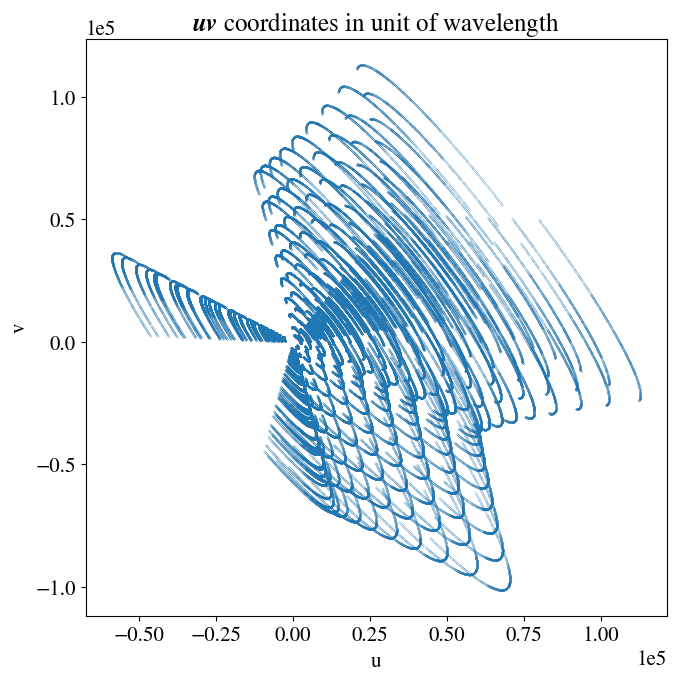

In [5]:
# plot the 2D Fourier sampling pattern
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.scatter(u, v, s=0.005)
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_title(r"$\boldsymbol{uv}$ coordinates in unit of wavelength")
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
# ax.

To generate the measurement operator, two crucial parameters need to be set: 
1. the ground-truth/target image dimension $N$,
2. the ratio between the spatial bandwidth of the ground-truth/target image and the bandwidth of the Fourier sampling, to which we refer to as the super-resolution factor $\ge 1$. The bandwidth of the Fourier sampling is given by the maximum projected baseline $\rm{max\_proj\_baseline} = \max{(\sqrt{\boldsymbol{u}^2 + \boldsymbol{v}^2})}$. 

Note that from the value of , one can compute the resulting pixel size of the ground-truth/target image in arcsec: 
\begin{equation}
\textrm{image\_pixel\_size} = \frac{180}{\pi} \times \frac{3600}{2 \times  \textrm{super\_resolution} \times \textrm{max\_proj\_baseline}}
\end{equation}

Consider a ground truth/target image $\bar{\boldsymbol{x}}$ of size $N = 512 \times 512$. For the sake of this demonstration, we consider $\textrm{super\_resolution}=1.5$, which means that the spatial bandwidth of the Fourier sampling corresponds to 2/3 the spatial Fourier bandwidth of the ground truth/target image.

In [8]:
super_resolution = 1.5
img_size = (512, 512)

data = load_data_to_tensor(
    uv_file_path=uvw_data_file_path,
    super_resolution=super_resolution,
    img_size=img_size,
)

INFO: loading sampling pattern from data/test.mat
INFO: converting uv coordinate unit from meters to wavelength.
INFO: user-specified pixel size: 5.6282e-01 arcsec (i.e. super resolution factor: 1.5000)
INFO: natural weights "nW" not found, set to 1.
INFO: computing imaging weights...
INFO: weight_robustness 0.0


In this tutorial we will generate the measurement operator using the `pytorch-finufft` package. The `pynufft` and `torchkbnufft` packages can be used as an alternative. The `Operator` class can be created by importing the corresponding class, then calling it with the required parameters, as shown below.

In [9]:
nufft_pkg = 'finufft'

match nufft_pkg:
    case "finufft":
        from pysrc.measOperator.meas_op_nufft_pytorch_finufft import MeasOpPytorchFinufft

        Operator = MeasOpPytorchFinufft
    case "tkbn":
        from pysrc.measOperator.meas_op_nufft_tkbn import MeasOpTkbNUFFT

        Operator = MeasOpTkbNUFFT
    case "pynufft":
        from pysrc.measOperator.meas_op_nufft_pynufft import MeasOpPynufft

        Operator = MeasOpPynufft
        
meas_op = Operator(
    u=data["u"],
    v=data["v"],
    img_size=img_size
)

Note that, the use can specify other parameters to the `Operator` class as shown below. Default values are used otherwise.

In [10]:
nufft_kernel_dim = 7
nufft_grid_size = tuple([2 * i for i in img_size])
natural_weight = data["nW"]
image_weight = data["nWimag"]
real_flag = True

meas_op_tmp = Operator(
    u=data["u"],
    v=data["v"],
    img_size=img_size,
    real_flag=real_flag,
    natural_weight=natural_weight,
    image_weight=image_weight,
    grid_size=nufft_grid_size,
    kernel_dim=nufft_kernel_dim
)


# Simulate RI Measurements
To simulate RI measurements, we take a post-processed image of the radio galaxy 3c353 as the ground truth $\bar{\boldsymbol{x}}$. The image is in **.fits** format provided in "data/3c353_gdth.fits". Read and visualise the image.

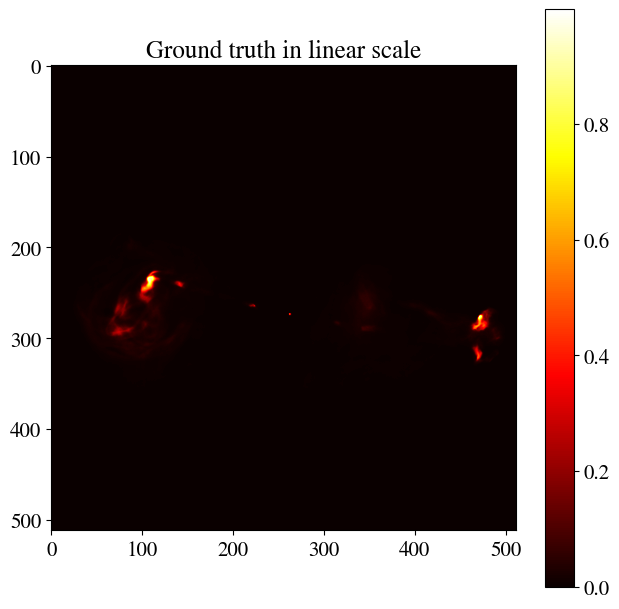

In [11]:
from astropy.io import fits
import matplotlib.pyplot as plt

gdth = fits.getdata('data/3c353_gdth.fits')
fig, ax = plt.subplots(figsize=(7.5, 7.5))
pcm = ax.imshow(gdth, cmap='hot')
ax.set_title("Ground truth in linear scale")
plt.colorbar(pcm, ax=ax)

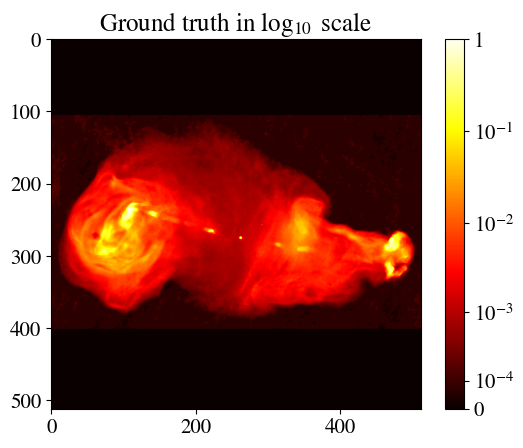

In [12]:
import numpy as np
import matplotlib.colors as colors

class rlog(colors.Normalize):
    def __init__(self, a):
        self.a = a
        super().__init__(vmin=None, vmax=None, clip=False)
        
    def __call__(self, im):
        if len(im) == 0:
            return im
        im_max = np.max(im)
        if im_max < 1/self.a:
            return im
        else:
            return im_max * np.log10(self.a * im / im_max + 1) / np.log10(self.a)

    def inverse(self, im):
        return (self.a**(im) - 1) / self.a

a = 1e4

norm = rlog(a)

fig, ax = plt.subplots()
pcm = ax.imshow(gdth, norm=norm, cmap='hot')
ax.set_title(r"Ground truth in $\log_{10}$ scale")
cb = plt.colorbar(pcm, ax=ax)

ticks = [np.log10(a * tick + 1)/np.log10(a) for tick in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]]
ticks[-1] = 1
cb.set_ticks(ticks)
cb.set_ticklabels([0, '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1'])

The *clean* visibilities are modelled as $\boldsymbol{y}_{\rm{clean}} = \boldsymbol{\Phi} \bar{\boldsymbol{x}}$.

In [13]:
gdth = torch.tensor(gdth.astype(float), dtype=torch.float64).view(1, 1, *gdth.shape)
y_clean = meas_op.forward_op(gdth)

RI measurements modelled as $\boldsymbol{y} = \boldsymbol{\Phi} \bar{\boldsymbol{x}} + \boldsymbol{n}$ are obtained by adding a realisation of a white Gaussian noise $\boldsymbol{n}$, with mean 0 and standard deviation $\tau$. The value of $\tau$ can be derived from a user-specfied input signal to noise ratio. Note that $\tau$ can also be set to be commensurate with the dynamic range of the ground-truth image. We refer the reader to the script [example_sim_ri_data.py](example_sim_ri_data.py) for details.

In [21]:
iSNR = 40 # user-specified input SNR
M = y_clean.numel()
tau = 10**(-iSNR / 20) * torch.linalg.norm(y_clean, dtype=torch.complex128) / sqrt(M) # calculate tau
noise = (torch.randn(M) + 1j * torch.randn(M)) / sqrt(2) # random Gaussian noise with std tau and mean 0
y = y_clean + noise # noisy measurement

To image the simulated RI measurements, create the associated measurement file in **.mat** format, that is input to the RI algorithms for small-scale monochromatic intensity imaging provided in [**BASPLib**](https://basp-group.github.io/BASPLib/index.html) as shown below.

In [23]:
nW = torch.ones(M) / tau # the inverse of the noise std
max_proj_baseline = np.sqrt(np.max(u**2 + v**2))
savemat("3c353_sim_data.mat", {
    "y": y.numpy().reshape(-1, 1),
    "nW": nW.numpy().reshape(-1, 1),
    "u": u.reshape(-1, 1),
    "v": v.reshape(-1, 1),
    "w": w.reshape(-1, 1),
    "frequency": frequency.item(),
})
print("Measurement file saved.")

Measurement file saved.


# Imaging Weighting Schemes
During imaging, a common practice is to apply a whitening operation to the measurements via point-wise multiplication with the inverse of the noise standard deviation. This is known as **natural weighting**. 

The natural weighting vector nW in our example is given by:

In [24]:
nW = torch.ones(M) / tau

Often, this is done in combination with an additional imaging weighting scheme to compensate for the unbalance of the Fourier sampling such as **uniform weighting** or **Briggs weighting** and consequently enhance the effective resolution of the reconstruction. 

the function [gen_imaging_weights.py](pysrc/utils/gen_imaging_weights.py) enables computing the imaging weights vector `nWimag` (see  for details). The final weighting vector is the product of the two, which is handled in the `Operator` class. 

In this example, we consider Briggs weighting with robust parameter 0. 

In [ ]:
nWimag = gen_imaging_weights(
    data["u"],
    data["v"],
    nW,
    img_size,
    weight_type="briggs",
    weight_robustness=0.0
)

During imaging, the final weighting vector `nW * nWimag` is applied to the RI measurements and is also included in the associated imaging measurement operator.

In [36]:
y_weighted = y * (nW * nWimag)
meas_op_weighted = Operator(
    u=data["u"],
    v=data["v"],
    img_size=img_size,
    real_flag=real_flag,
    natural_weight=nW,
    image_weight=nWimag,
    grid_size=nufft_grid_size,
    kernel_dim=nufft_kernel_dim,
    dtype=torch.float64
)

# PSF & Dirty Image
The point spread function (PSF) is defined as $\boldsymbol{h} = \kappa \rm{Re}\{\boldsymbol{\Phi}^\dagger \boldsymbol{\Phi} \boldsymbol{\delta}\}$, with $\boldsymbol{\delta}$ a Dirac delta image (with value 1 at its centre and 0 otherwise), and $\kappa$ a normalisation factor ensuring that its peak value is equal to 1.

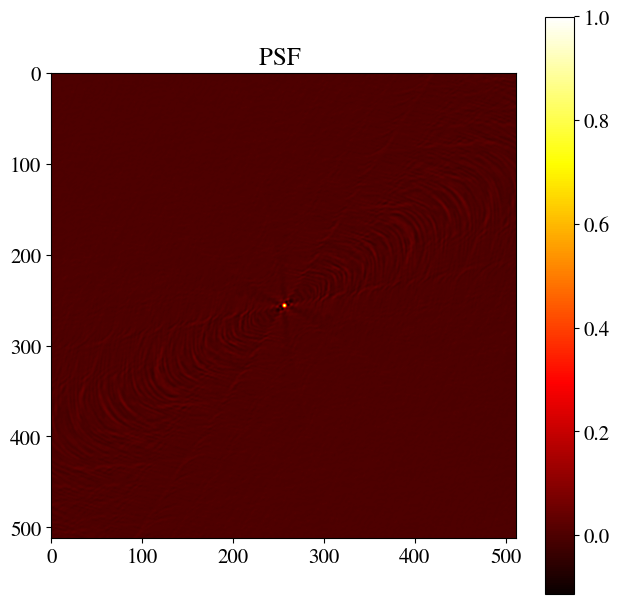

In [37]:
dirac = torch.zeros(1, 1, *img_size, dtype=torch.float64)
dirac[0, 0, img_size[0] // 2, img_size[1] // 2] = 1
psf_0 = meas_op_weighted.adjoint_op(meas_op_weighted.forward_op(dirac))
kappa = 1 / torch.max(psf_0)
psf = psf_0 * kappa

fig, ax = plt.subplots(figsize=(7.5, 7.5))
pcm = ax.imshow(psf[0, 0].numpy(), cmap='hot')
ax.set_title("PSF ")
plt.colorbar(pcm, ax=ax)

The normalised back-projected data, also known as the dirty image, is defined as $\boldsymbol{x}_{d} = \kappa \rm{Re}\{\boldsymbol{\Phi}^\dagger \boldsymbol{y}\}$.

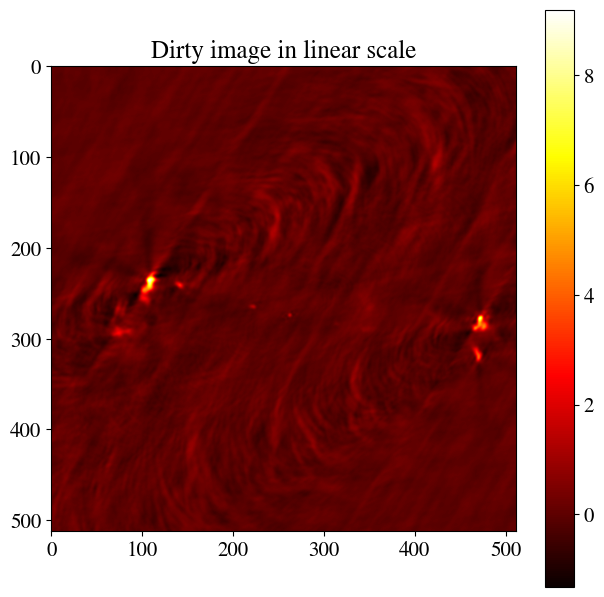

In [42]:
dirty = kappa * meas_op_weighted.adjoint_op(y_weighted)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
pcm = ax.imshow(dirty[0, 0].numpy(), cmap='hot')
ax.set_title("Dirty image in linear scale")
plt.colorbar(pcm, ax=ax)